In [69]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
bus = pd.read_excel('../data_original/Headway Data, 8-1-2023 to 9-30-2023.xlsx', sheet_name = 'Sheet1')

In [14]:
weather = pd.read_csv('../data_original/bna_weather.csv')

In [15]:
bus.to_csv('../data_original/headway_data.csv', index = False) # so I never have to read in the excel file again (very slow)

In [6]:
bus.head()

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,ACTUAL_HDWY,HDWY_DEV,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,BLOCK_STOP_ORDER,DWELL_IN_MINS
0,120230801,1,99457890,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,2,6.500000
1,120230801,1,99457891,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,9,0.000000
2,120230801,1,99457892,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,19,0.000000
3,120230801,1,99457893,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,NaN,0,35,0.000000
4,120230801,1,99457894,2023-08-01,22,2200,1040,345105,0,FROM DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,36,12.866666


In [7]:
bus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350328 entries, 0 to 350327
Data columns (total 30 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   CALENDAR_ID                350328 non-null  int64         
 1   SERVICE_ABBR               350328 non-null  int64         
 2   ADHERENCE_ID               350328 non-null  int64         
 3   DATE                       350328 non-null  datetime64[ns]
 4   ROUTE_ABBR                 350328 non-null  int64         
 5   BLOCK_ABBR                 350328 non-null  int64         
 6   OPERATOR                   350328 non-null  int64         
 7   TRIP_ID                    350328 non-null  int64         
 8   OVERLOAD_ID                350328 non-null  int64         
 9   ROUTE_DIRECTION_NAME       350328 non-null  object        
 10  TIME_POINT_ABBR            350328 non-null  object        
 11  ROUTE_STOP_SEQUENCE        350317 non-null  float64 

Columns:
- CALENDAR_ID: related to date, but is there anything special about it? notice the 1 prepended
- SERVICE_ABBR: what does this represent
- ADHERANCE_ID: 
- DATE: date of the trip
- ROUTE_ABBR: is this the route number?
- BLOCK_ABBR: 
- OPERATOR: is this the id of the driver?
- TRIP_ID: 
- OVERLOAD_ID: 
- ROUTE_DIRECTION_NAME: in and outbound, Nashville is hub and spoke bus system so it all comes in and out of downtown
- TIME_POINT_ABBR: 
- ROUTE_STOPE_SEQUENCE: what stop (ordered, probably starting from downtown but confirm)
- TRIP_EDGE: 
- LATITUDE: part of bus location, no nulls (good sign)
- LONGITUDE: ditto what I said about latitude
- SCHEDULED_TIME: when the bus was scheduled to be at the particular stop? (indicated by ROUTE_STOP_SEQUENCE?)
- ACTUAL_ARRIVAL_TIME: when the bus got to the stop
- ACTUAL_DEPARTURE_TIME: when the bus left the stop
- ADHERANCE: this looks like it might be the time difference between when the bus was supposed to leave the stop and when it actually did
- SCHEDULED_HDWY: scheduled time between bus arrivals at the stop, why are there so many nulls?
- ACTUAL_HEADWAY: actual time between bus arrivals at the stop, many nulls
- HDWY_DEV: difference betwee scheduled and actual headway, many nulls
- ADJUSTED_EARLY_COUNT: 
- ADJUSTED_LATE_COUNT: 
- ADJUSTED_ONTIME_COUNT: I think these three columns are boolean for classifying timeliness (can tell for sure if one and only one has a value of 1 in each row which does look to be the case)
- STOP_CANCELLED: is this to indicate if the bus skipped the particular stop?
- PREV_SCHEDULED_STOP_CANCELLED: 
- IS_RELIEF: indicates replacement bus?
- BLOCK_STOP_ORDER:
- DWELL_IN_MINS: looks like how long the bus sat at that stop

In [9]:
bus['ROUTE_ABBR'].unique()

array([22, 23,  3,  7, 50, 52, 55, 56])

In [16]:
bus_csv = pd.read_csv('../data_original/headway_data.csv')

In [18]:
bus_csv['SERVICE_ABBR'].value_counts()
# 1 is weekday, 2 is Saturday, 3 is Sunday
# are there days where the service type does not match the actual calendar day?

1    279299
2     37497
3     33532
Name: SERVICE_ABBR, dtype: int64

1. How much impact does being late or too spaced out at the first stop have downstream?

Partition by trip ID and order by actual arrival time - this should get each trip in the right order.
Data dictionary says TRIP_EDGE == 1 for the first stop on the trip. When I first looked at that I thought that meant it was either the bus station downtown or the stop from which the bus started the return journey. Doublecheck.
Segment by to or from downtown in the analysis to see if that is also a factor.
How does headway deviation (which s actual - expected) vary across the route?
Most basic - use correlation to see how adherance at TRIP_EDGE == 1 correlates with adherance at TRIP_EDGE == 2. There are many fewer nulls in the adherance column vs headway columns.

In [21]:
bus_csv.sort_values(by = ['TRIP_ID', 'DATE', 'SCHEDULED_TIME'])

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,ACTUAL_HDWY,HDWY_DEV,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,BLOCK_STOP_ORDER,DWELL_IN_MINS
0,120230801,1,99457890,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,2,6.500000
1,120230801,1,99457891,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,9,0.000000
2,120230801,1,99457892,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,19,0.000000
3,120230801,1,99457893,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,NaN,0,35,0.000000
6461,120230802,1,99491784,2023-08-02,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,2,9.816666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333129,120230927,1,100323018,2023-09-27,56,9975,1880,354106,0,TO DOWNTOWN,...,NaN,NaN,0,1,0,0,NaN,0,3,0.116666
339627,120230928,1,100357073,2023-09-28,56,9975,1880,354106,0,TO DOWNTOWN,...,2.283333,2.283333,0,0,1,0,0.0,0,2,22.283333
339628,120230928,1,100357074,2023-09-28,56,9975,1880,354106,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,NaN,0,3,4.583333
346168,120230929,1,100386749,2023-09-29,56,9975,3120,354106,0,TO DOWNTOWN,...,20.450000,20.450000,0,1,0,0,0.0,0,2,10.433333


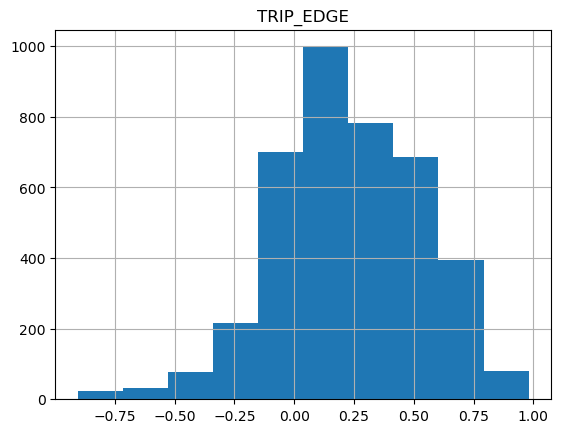

In [38]:
bus_csv.groupby('TRIP_ID')[['ADHERENCE', 'TRIP_EDGE']].corr().iloc[0::2][['TRIP_EDGE']].hist();
# not quite right, needs to be the adherance at each end correlated


array([[<Axes: title={'center': 'TRIP_EDGE'}>]], dtype=object)

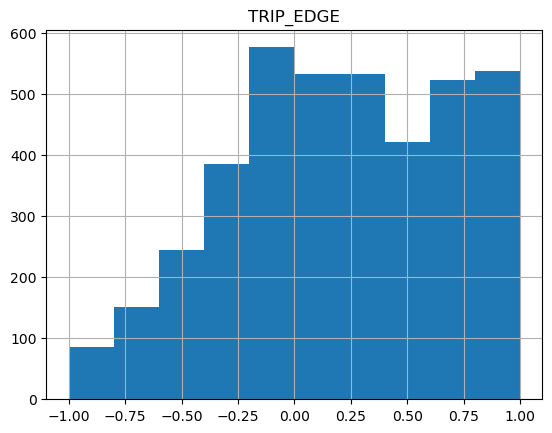

In [40]:
bus_csv.loc[bus_csv['TRIP_EDGE'].isin([1, 2])].groupby('TRIP_ID')[['ADHERENCE', 'TRIP_EDGE']].corr().iloc[0::2][['TRIP_EDGE']].hist()
# not entirely satisfied with this

In [67]:
# scatterplot with first stop adherance and last stop adherance on the axes

trip_beg_end = bus_csv[bus_csv['TRIP_EDGE'].isin([1, 2])]

edge_1 = bus_csv[bus_csv['TRIP_EDGE'] == 1][['TRIP_ID', 'ADHERENCE']]
edge_2 = bus_csv[bus_csv['TRIP_EDGE'] == 2][['TRIP_ID', 'ADHERENCE']]

trip_beg_end = pd.merge(edge_1, edge_2, on = 'TRIP_ID', suffixes = ('_1', '_2'))

adherence_corr = trip_beg_end.groupby('TRIP_ID').apply(lambda x: x['ADHERENCE_1'].corr(x['ADHERENCE_2'])).reset_index()
adherence_corr.columns = ['TRIP_ID', 'Correlation']


''

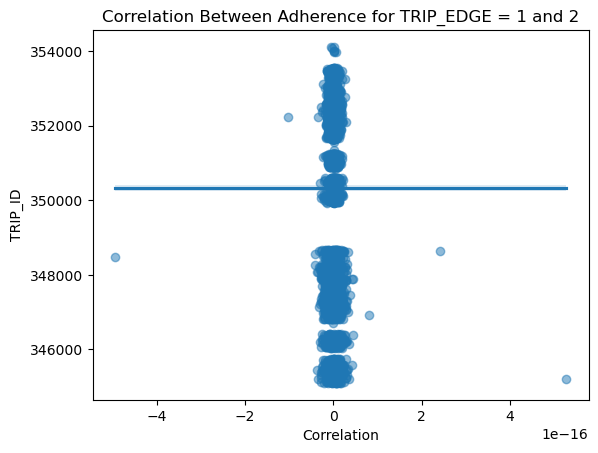

In [71]:
sns.regplot(x = adherence_corr['Correlation'], y = adherence_corr['TRIP_ID'], scatter_kws = {'alpha': 0.5})
plt.xlabel('Correlation')
plt.ylabel('TRIP_ID')
plt.title('Correlation Between Adherence for TRIP_EDGE = 1 and 2')
;

# same story different verse if I did this correctly

In [ ]:
# try the above approach, but with adjusted late count, I find it hard to believe that there's no correlation between lateness at the beginning and end of the route, unless they're consistently building in
# too much headway. Actually that's a potentially interesting question - is a route scheduled to take the same amount of time regardless of time of day and could timing be changed so that buses weren't sitting at stops
# for long periods on some trips?